In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import numpy as np

In [2]:
sns.set_style('whitegrid')

Download the dataset here:

https://www.kaggle.com/datasets/muhammadtalhaawan/world-sugar-dataset-2018-2024

In [3]:
df = pd.read_csv('./data/sugar/combined_df.csv')

In [4]:
df

,Name,Action,2018/19,2019/20,2020/21,2021/22,2022/23,May2023/24
0,Algeria,consumption,"2,080","2,124","1,936","1,889","1,682","1,897"
1,Algeria,ending,420,430,387,377,336,375
2,Algeria,export,208,334,364,366,360,365
3,Algeria,import,"2,328","2,468","2,257","2,245","2,001","2,301"
4,Argentina,production,"1,570","1,750","1,830","1,700","1,670","1,690"
...,...,...,...,...,...,...,...,...
130,Vietnam,ending,320,415,415,455,485,505
131,Vietnam,import,303,"1,312","1,325","1,490","1,520","1,575"
132,Vietnam,production,"1,300",850,750,820,950,975
133,Yemen,import,667,770,941,466,775,875


In [5]:
df.query('Action == "consumption"')['2018/19'].apply(lambda x: float(x.replace(',',''))).describe()

count        27.000000
mean      12740.296296
std       32892.274599
min         832.000000
25%        1919.000000
50%        2519.000000
75%        8827.500000
max      171994.000000
Name: 2018/19, dtype: float64

In [6]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

In [7]:
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='10m',
                                     category='cultural', name=shapename)

In [8]:
def country_sugar_consumption(lower, upper):
    country_list = []
    
    for record in shpreader.Reader(countries_shp).records():
        country = record.attributes['NAME']
        consumption = df.query('(Name == @country) & (Action == "consumption")')['2018/19']
        if len(consumption) == 0:
            continue
        consumption = float(consumption.values[0].replace(',',''))
    
        if consumption > lower and consumption <= upper:
            country_list.append(record.geometry)
            
    return country_list

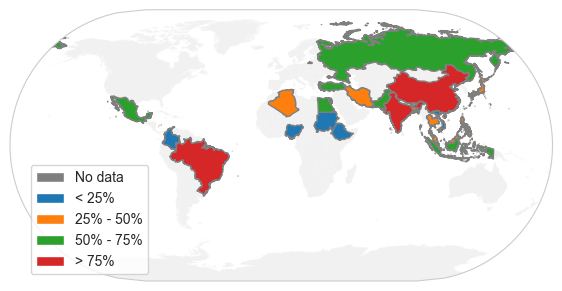

In [9]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(projection=ccrs.EckertIII())

# Add all countries
ax.add_geometries(shpreader.Reader(countries_shp).geometries(),
                  ccrs.PlateCarree(),
                  facecolor='C7', alpha=0.1
                 )

# All countries with sugar consumption in bottom 25%
ax.add_geometries(
    country_sugar_consumption(0, 1919),
    ccrs.PlateCarree(),
    facecolor='C0', edgecolor='C7')

# All countries with sugar consumption in 25% - 50%
ax.add_geometries(
    country_sugar_consumption(1919, 2519),
    ccrs.PlateCarree(),
    facecolor='C1', edgecolor='C7')

# All countries with sugar consumption in 50% - 75%
ax.add_geometries(
    country_sugar_consumption(2519, 8827),
    ccrs.PlateCarree(),
    facecolor='C2', edgecolor='C7')

# All countries with sugar consumption in 75% - 100%
ax.add_geometries(
    country_sugar_consumption(8827, 1e9),
    ccrs.PlateCarree(),
    facecolor='C3', edgecolor='C7')

# Legend items
q0 = mpatches.Rectangle((0, 0), 1, 1, facecolor='C0')
q1 = mpatches.Rectangle((0, 0), 1, 1, facecolor='C1')
q2 = mpatches.Rectangle((0, 0), 1, 1, facecolor='C2')
q3 = mpatches.Rectangle((0, 0), 1, 1, facecolor='C3')
q4 = mpatches.Rectangle((0, 0), 1, 1, facecolor='C7')

labels = ['No data', '< 25%', '25% - 50%', '50% - 75%', '> 75%']

ax.legend([q4, q0, q1, q2, q3], labels,
        loc='lower left', bbox_to_anchor=(0.025, 0), fancybox=True)

plt.savefig('./plots/2023-12-15-sugar-consumption.png', bbox_inches='tight', dpi=150)

In [10]:
def country_sugar_export():
    country_list = []
    
    for record in shpreader.Reader(countries_shp).records():
        country = record.attributes['NAME']
        consumption = df.query('(Name == @country) & (Action == "consumption")')['2018/19']
        if len(consumption) == 0:
            continue
        consumption = float(consumption.values[0].replace(',',''))
        
        export = df.query('(Name == @country) & (Action == "export")')['2018/19']
        if len(export) == 0:
            continue
        export = float(export.values[0].replace(',',''))
        
    
        if export > consumption:
            country_list.append(record.geometry)
            
    return country_list

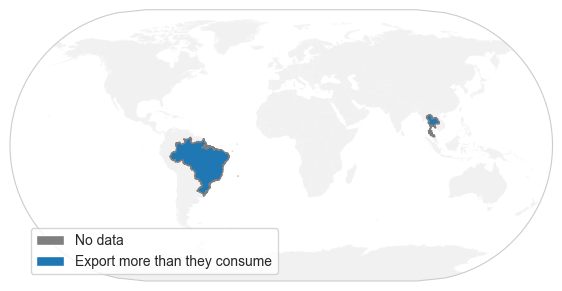

In [11]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(projection=ccrs.EckertIII())

# Add all countries
ax.add_geometries(shpreader.Reader(countries_shp).geometries(),
                  ccrs.PlateCarree(),
                  facecolor='C7', alpha=0.1
                 )

# All countries with sugar export higher than consumption
ax.add_geometries(
    country_sugar_export(),
    ccrs.PlateCarree(),
    facecolor='C0', edgecolor='C7')

# Legend items
q0 = mpatches.Rectangle((0, 0), 1, 1, facecolor='C0')
q4 = mpatches.Rectangle((0, 0), 1, 1, facecolor='C7')

labels = ['No data', 'Export more than they consume']

ax.legend([q4, q0], labels,
        loc='lower left', bbox_to_anchor=(0.025, 0), fancybox=True)

plt.savefig('./plots/2023-12-15-sugar-export.png', bbox_inches='tight', dpi=150)

In [12]:
def country_sugar_growth(is_growing):
    country_list = []
    
    for record in shpreader.Reader(countries_shp).records():
        country = record.attributes['NAME']
        consumption = df.query('(Name == @country) & (Action == "consumption")')['2018/19']
        if len(consumption) == 0:
            continue
        consumption = float(consumption.values[0].replace(',',''))
        
        consumption2 = df.query('(Name == @country) & (Action == "consumption")')['2022/23']
        if len(consumption2) == 0:
            continue
        consumption2 = float(consumption2.values[0].replace(',',''))
        
        if is_growing:
            if consumption2 > consumption:
                country_list.append(record.geometry)
        else:
            if consumption2 < consumption:
                country_list.append(record.geometry)

    return country_list

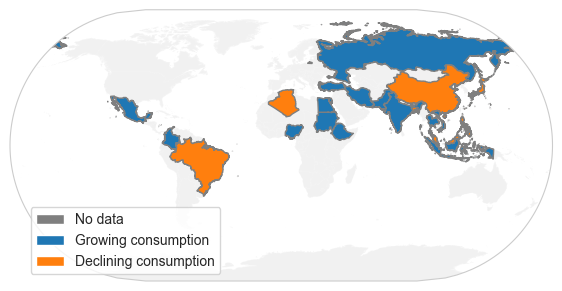

In [13]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(projection=ccrs.EckertIII())

# Add all countries
ax.add_geometries(shpreader.Reader(countries_shp).geometries(),
                  ccrs.PlateCarree(),
                  facecolor='C7', alpha=0.1
                 )

# All countries with growing sugar consumption
ax.add_geometries(
    country_sugar_growth(True),
    ccrs.PlateCarree(),
    facecolor='C0', edgecolor='C7')

# All countries with declining sugar consumption
ax.add_geometries(
    country_sugar_growth(False),
    ccrs.PlateCarree(),
    facecolor='C1', edgecolor='C7')

# Legend items
q0 = mpatches.Rectangle((0, 0), 1, 1, facecolor='C0')
q1 = mpatches.Rectangle((0, 0), 1, 1, facecolor='C1')
q4 = mpatches.Rectangle((0, 0), 1, 1, facecolor='C7')

labels = ['No data', 'Growing consumption', 'Declining consumption']

ax.legend([q4, q0, q1], labels,
        loc='lower left', bbox_to_anchor=(0.025, 0), fancybox=True)

plt.savefig('./plots/2023-12-15-sugar-growth.png', bbox_inches='tight', dpi=150)